In [2]:
#Importing libraries
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
import time
import matplotlib.pyplot as plt

## 1. One day ahead forecasting using SARIMA model

### 1.1. One day ahead forecasting using SARIMA model for the month of APRIL:



 we will use this code to check the accuracy of the SARIMA model to compare with(ANN,SARIMAX AND Holt-Winters model) other models .  we are doing this to select the best two models among SARIMA, ANN,SARIMAX AND Holt-Winters model. (NOTE: # we are testing our model and our model will only predict whether next day is a peak day or not. so we will only forecast one day add actual data of that day to train data to retrain)

In [13]:
# Loading the data
file_path = 'Database_1_capped.csv'  
print("Loading data...") 
data = pd.read_csv(file_path)

# Converting 'Date and Time' to datetime 
data['Date and Time'] = pd.to_datetime(data['Date and Time'], format='%d/%m/%Y %H:%M', errors='coerce')
data.dropna(subset=['Date and Time'], inplace=True)
data.set_index('Date and Time', inplace=True)
data = data.asfreq('30T') 

# Applying log transformation to stabilize variance
data['Log_Demand'] = np.log(data['Demand_Capped'] + 1)  # Adding 1 to handle zero values safely

# Defining the target variable
target_series = data['Log_Demand']

# Defining the fixed training period
train_start = '2020-04-01'
train_end = '2021-03-31'
train_data = target_series[train_start:train_end]

# Defining the test period
test_start = '2021-04-01'
test_end = '2021-04-30'
test_dates = pd.date_range(start=test_start, end=test_end, freq='D')

# Training the SARIMA model once
print("Training SARIMA model on the full training dataset...")
start_time = time.time()
model = SARIMAX(
    train_data,
    order=(4, 1, 3),
    seasonal_order=(1, 0, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)
fitted_model = model.fit(disp=False, maxiter=500, method='lbfgs')
end_time = time.time()
print(f"Model training completed in {end_time - start_time:.2f} seconds.\n")

# Initializing a DataFrame to store actual and forecasted values
comparison_df = pd.DataFrame(columns=['Date and Time', 'Actual', 'Forecast'])

# Generatint rolling forecasts for the entire test period
print("Generating rolling forecasts for the test period...")
for forecast_date in test_dates:
    print(f"Forecasting for {forecast_date}...")

    # Forecasting from 12 AM of the forecast_date to 11:30 PM of the same day
    forecast_start = forecast_date
    forecast_steps = 48  # Total of 48 intervals (24 hours at 30-minute intervals)
    forecast_index = pd.date_range(start=forecast_start, periods=forecast_steps, freq='30T')

    # Generating forecasts
    forecast = fitted_model.get_forecast(steps=forecast_steps)
    forecast_mean = forecast.predicted_mean
    forecast_series = pd.Series(np.exp(forecast_mean) - 1, index=forecast_index)  # Reverse log transformation

    # Stoing the forecast for the current day
    for forecast_time in forecast_index:
        actual = data['Demand_Capped'][forecast_time] if forecast_time in data.index else None
        forecast_value = forecast_series[forecast_time]
        new_row = pd.DataFrame({
            'Date and Time': [forecast_time],
            'Actual': [actual],
            'Forecast': [forecast_value]
        })
        comparison_df = pd.concat([comparison_df, new_row], ignore_index=True)

    # Appending the actual data from the test set for the forecasted date to the training data
    actual_data_for_day = data['Log_Demand'].loc[forecast_index]  # we are testing our model and our model will only predict whether next day is a peak day or not. so we will only forecast one day add actual data of that day to train data to retain
    
    train_data = pd.concat([train_data, actual_data_for_day])

    # Retraining the model with the updated training data
    print("Retraining model with updated training data...")
    model = SARIMAX(
        train_data,
        order=(4, 1, 3),
        seasonal_order=(1, 0, 1, 24),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False, maxiter=500, method='lbfgs')

# Calculating MAD and MAPE for the entire dataset
comparison_df.dropna(subset=['Actual'], inplace=True)
mad = (comparison_df['Actual'] - comparison_df['Forecast']).abs().mean()
mape = ((comparison_df['Actual'] - comparison_df['Forecast']).abs() / comparison_df['Actual']).mean() * 100

# Displaying MAD and MAPE
print(f"\nMean Absolute Deviation (MAD): {mad:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Saving results to CSV
comparison_df.to_csv('sarima_rolling_forecast-april.csv', index=False)

# Printing the forecasted values for the test range
print("\nDaily Forecasts for Test Range (12 AM to 11:30 PM):")
print(comparison_df.head())


Loading data...
Training SARIMA model on the full training dataset...
Model training completed in 65.52 seconds.

Generating rolling forecasts for the test period...
Forecasting for 2021-04-01 00:00:00...
Retraining model with updated training data...


/var/folders/tn/v941jp4540374j7s4hp2b37w0000gn/T/ipykernel_46188/4069601088.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparison_df = pd.concat([comparison_df, new_row], ignore_index=True)


Forecasting for 2021-04-02 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-03 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-04 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-05 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-06 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-07 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-08 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-09 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-10 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-11 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-12 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-13 00:00:00...
Retraining mode

### Result:
      Mean Absolute Deviation (MAD): 637.46
      Mean Absolute Percentage Error (MAPE): 6.16%


In [ ]:
print(fitted_model.summary())

### 1.2. Testing one day ahead forecasting model for the entire year 2021 by retraining the model daily.



 We will forecast the demand throughout 2021 and save the actual vs forecast in a csv to use this csv to flag PELDS using 95th Percentile method.

In [8]:
# Loading the data
file_path = 'Database_1_capped.csv'  
print("Loading data...")
data = pd.read_csv(file_path)

# Converting 'Date and Time' to datetime 
data['Date and Time'] = pd.to_datetime(data['Date and Time'], format='%d/%m/%Y %H:%M', errors='coerce')
data.dropna(subset=['Date and Time'], inplace=True)
data.set_index('Date and Time', inplace=True)
data = data.asfreq('30T')  

# Applying log transformation to stabilize variance
data['Log_Demand'] = np.log(data['Demand_Capped'] + 1)  # Adding 1 to handle zero values safely

# Defining the target variable
target_series = data['Log_Demand']

# Defining the fixed training period
train_start = '2019-01-01'
train_end = '2020-12-31'
train_data = target_series[train_start:train_end]

# Defining the test period
test_start = '2021-01-01'
test_end = '2021-12-31'
test_dates = pd.date_range(start=test_start, end=test_end, freq='D')

# Training the SARIMA model once
print("Training SARIMA model on the full training dataset...")
start_time = time.time()
model = SARIMAX(
    train_data,
    order=(4, 1, 3),
    seasonal_order=(1, 0, 1, 24),
    enforce_stationarity=False,
    enforce_invertibility=False
)
fitted_model = model.fit(disp=False, maxiter=500, method='lbfgs')
end_time = time.time()
print(f"Model training completed in {end_time - start_time:.2f} seconds.\n")

# Initializing a DataFrame to store actual and forecasted values
comparison_df = pd.DataFrame(columns=['Date and Time', 'Actual', 'Forecast'])

# Generating rolling forecasts for the entire test period
print("Generating rolling forecasts for the test period...")
for forecast_date in test_dates:
    print(f"Forecasting for {forecast_date}...")

    # Forecasting from 12 AM of the forecast_date to 11:30 PM of the same day
    forecast_start = forecast_date
    forecast_steps = 48  # Total of 48 intervals (24 hours at 30-minute intervals)
    forecast_index = pd.date_range(start=forecast_start, periods=forecast_steps, freq='30T')

    # Generating forecasts
    forecast = fitted_model.get_forecast(steps=forecast_steps)
    forecast_mean = forecast.predicted_mean
    forecast_series = pd.Series(np.exp(forecast_mean) - 1, index=forecast_index)  # Reverse log transformation

    # Storing the forecast for the current day
    for forecast_time in forecast_index:
        actual = data['Demand_Capped'][forecast_time] if forecast_time in data.index else None
        forecast_value = forecast_series[forecast_time]
        new_row = pd.DataFrame({
            'Date and Time': [forecast_time],
            'Actual': [actual],
            'Forecast': [forecast_value]
        })
        comparison_df = pd.concat([comparison_df, new_row], ignore_index=True)

    # Appending the actual data from the test set for the forecasted date to the training data
    actual_data_for_day = data['Log_Demand'].loc[forecast_index]  # Get actual test data for the forecast day
    
    train_data = pd.concat([train_data, actual_data_for_day])

    # Retraining the model with the updated training data
    print("Retraining model with updated training data...")
    model = SARIMAX(
        train_data,
        order=(4, 1, 3),
        seasonal_order=(1, 0, 1, 24),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    fitted_model = model.fit(disp=False, maxiter=500, method='lbfgs')

# Calculating MAD and MAPE for the entire dataset
comparison_df.dropna(subset=['Actual'], inplace=True)
mad = (comparison_df['Actual'] - comparison_df['Forecast']).abs().mean()
mape = ((comparison_df['Actual'] - comparison_df['Forecast']).abs() / comparison_df['Actual']).mean() * 100

# Displaying MAD and MAPE
print(f"\nMean Absolute Deviation (MAD): {mad:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Saving results to CSV
comparison_df.to_csv('sarima_rolling_forecast5.csv', index=False) # we will use this csv "sarima_rolling_forecast5.csv" for thr peld flagging

# Printing the forecasted values for the test range
print("\nDaily Forecasts for Test Range (12 AM to 11:30 PM):")
print(comparison_df.head())


Loading data...
Training SARIMA model on the full training dataset...
Model training completed in 111.24 seconds.

Generating rolling forecasts for the test period...
Forecasting for 2021-01-01 00:00:00...
Retraining model with updated training data...


/var/folders/tn/v941jp4540374j7s4hp2b37w0000gn/T/ipykernel_46188/1581691683.py:76: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  comparison_df = pd.concat([comparison_df, new_row], ignore_index=True)


Forecasting for 2021-01-02 00:00:00...
Retraining model with updated training data...


/Users/sivakumar/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasting for 2021-01-03 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-04 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-05 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-06 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-07 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-08 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-09 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-10 00:00:00...
Retraining model with updated training data...


/Users/sivakumar/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasting for 2021-01-11 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-12 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-13 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-14 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-15 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-16 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-17 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-18 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-19 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-20 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-21 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-01-22 00:00:00...
Retraining mode

/Users/sivakumar/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasting for 2021-02-23 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-02-24 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-02-25 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-02-26 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-02-27 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-02-28 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-03-01 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-03-02 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-03-03 00:00:00...
Retraining model with updated training data...


/Users/sivakumar/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasting for 2021-03-04 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-03-05 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-03-06 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-03-07 00:00:00...
Retraining model with updated training data...


/Users/sivakumar/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasting for 2021-03-08 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-03-09 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-03-10 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-03-11 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-03-12 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-03-13 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-03-14 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-03-15 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-03-16 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-03-17 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-03-18 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-03-19 00:00:00...
Retraining mode

/Users/sivakumar/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasting for 2021-04-08 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-09 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-10 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-11 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-12 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-13 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-14 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-15 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-16 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-17 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-18 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-04-19 00:00:00...
Retraining mode

/Users/sivakumar/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasting for 2021-05-14 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-05-15 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-05-16 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-05-17 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-05-18 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-05-19 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-05-20 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-05-21 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-05-22 00:00:00...
Retraining model with updated training data...


/Users/sivakumar/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasting for 2021-05-23 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-05-24 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-05-25 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-05-26 00:00:00...
Retraining model with updated training data...


/Users/sivakumar/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasting for 2021-05-27 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-05-28 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-05-29 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-05-30 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-05-31 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-06-01 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-06-02 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-06-03 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-06-04 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-06-05 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-06-06 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-06-07 00:00:00...
Retraining mode

/Users/sivakumar/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasting for 2021-06-30 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-07-01 00:00:00...
Retraining model with updated training data...


/Users/sivakumar/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Forecasting for 2021-07-02 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-07-03 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-07-04 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-07-05 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-07-06 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-07-07 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-07-08 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-07-09 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-07-10 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-07-11 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-07-12 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-07-13 00:00:00...
Retraining mode

/Users/sivakumar/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasting for 2021-08-16 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-08-17 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-08-18 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-08-19 00:00:00...
Retraining model with updated training data...


/Users/sivakumar/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasting for 2021-08-20 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-08-21 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-08-22 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-08-23 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-08-24 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-08-25 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-08-26 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-08-27 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-08-28 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-08-29 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-08-30 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-08-31 00:00:00...
Retraining mode

/Users/sivakumar/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasting for 2021-11-15 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-11-16 00:00:00...
Retraining model with updated training data...


/Users/sivakumar/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasting for 2021-11-17 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-11-18 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-11-19 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-11-20 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-11-21 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-11-22 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-11-23 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-11-24 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-11-25 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-11-26 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-11-27 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-11-28 00:00:00...
Retraining mode

/Users/sivakumar/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasting for 2021-12-02 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-03 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-04 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-05 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-06 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-07 00:00:00...
Retraining model with updated training data...


/Users/sivakumar/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasting for 2021-12-08 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-09 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-10 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-11 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-12 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-13 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-14 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-15 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-16 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-17 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-18 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-19 00:00:00...
Retraining mode

/Users/sivakumar/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Forecasting for 2021-12-24 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-25 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-26 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-27 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-28 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-29 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-30 00:00:00...
Retraining model with updated training data...
Forecasting for 2021-12-31 00:00:00...
Retraining model with updated training data...

Mean Absolute Deviation (MAD): 808.83
Mean Absolute Percentage Error (MAPE): 6.84%

Daily Forecasts for Test Range (12 AM to 11:30 PM):
        Date and Time   Actual      Forecast
0 2021-01-01 00:00:00  10158.0  10170.508083
1 2021-01-01 00:30:00   9925.5  10020.834704
2 2021-01-01 01:00:00   9693.0   9886.97

#### After testing for the whole year(2021) with sarima we got 
     Mean Absolute Deviation (MAD): 808.83
     Mean Absolute Percentage Error (MAPE): 6.84%


 This is our output csv "sarima_rolling_forecast5.csv" which is having forecasts of sarima for the demand throughout 2021.

In [ ]:
print(fitted_model.summary())

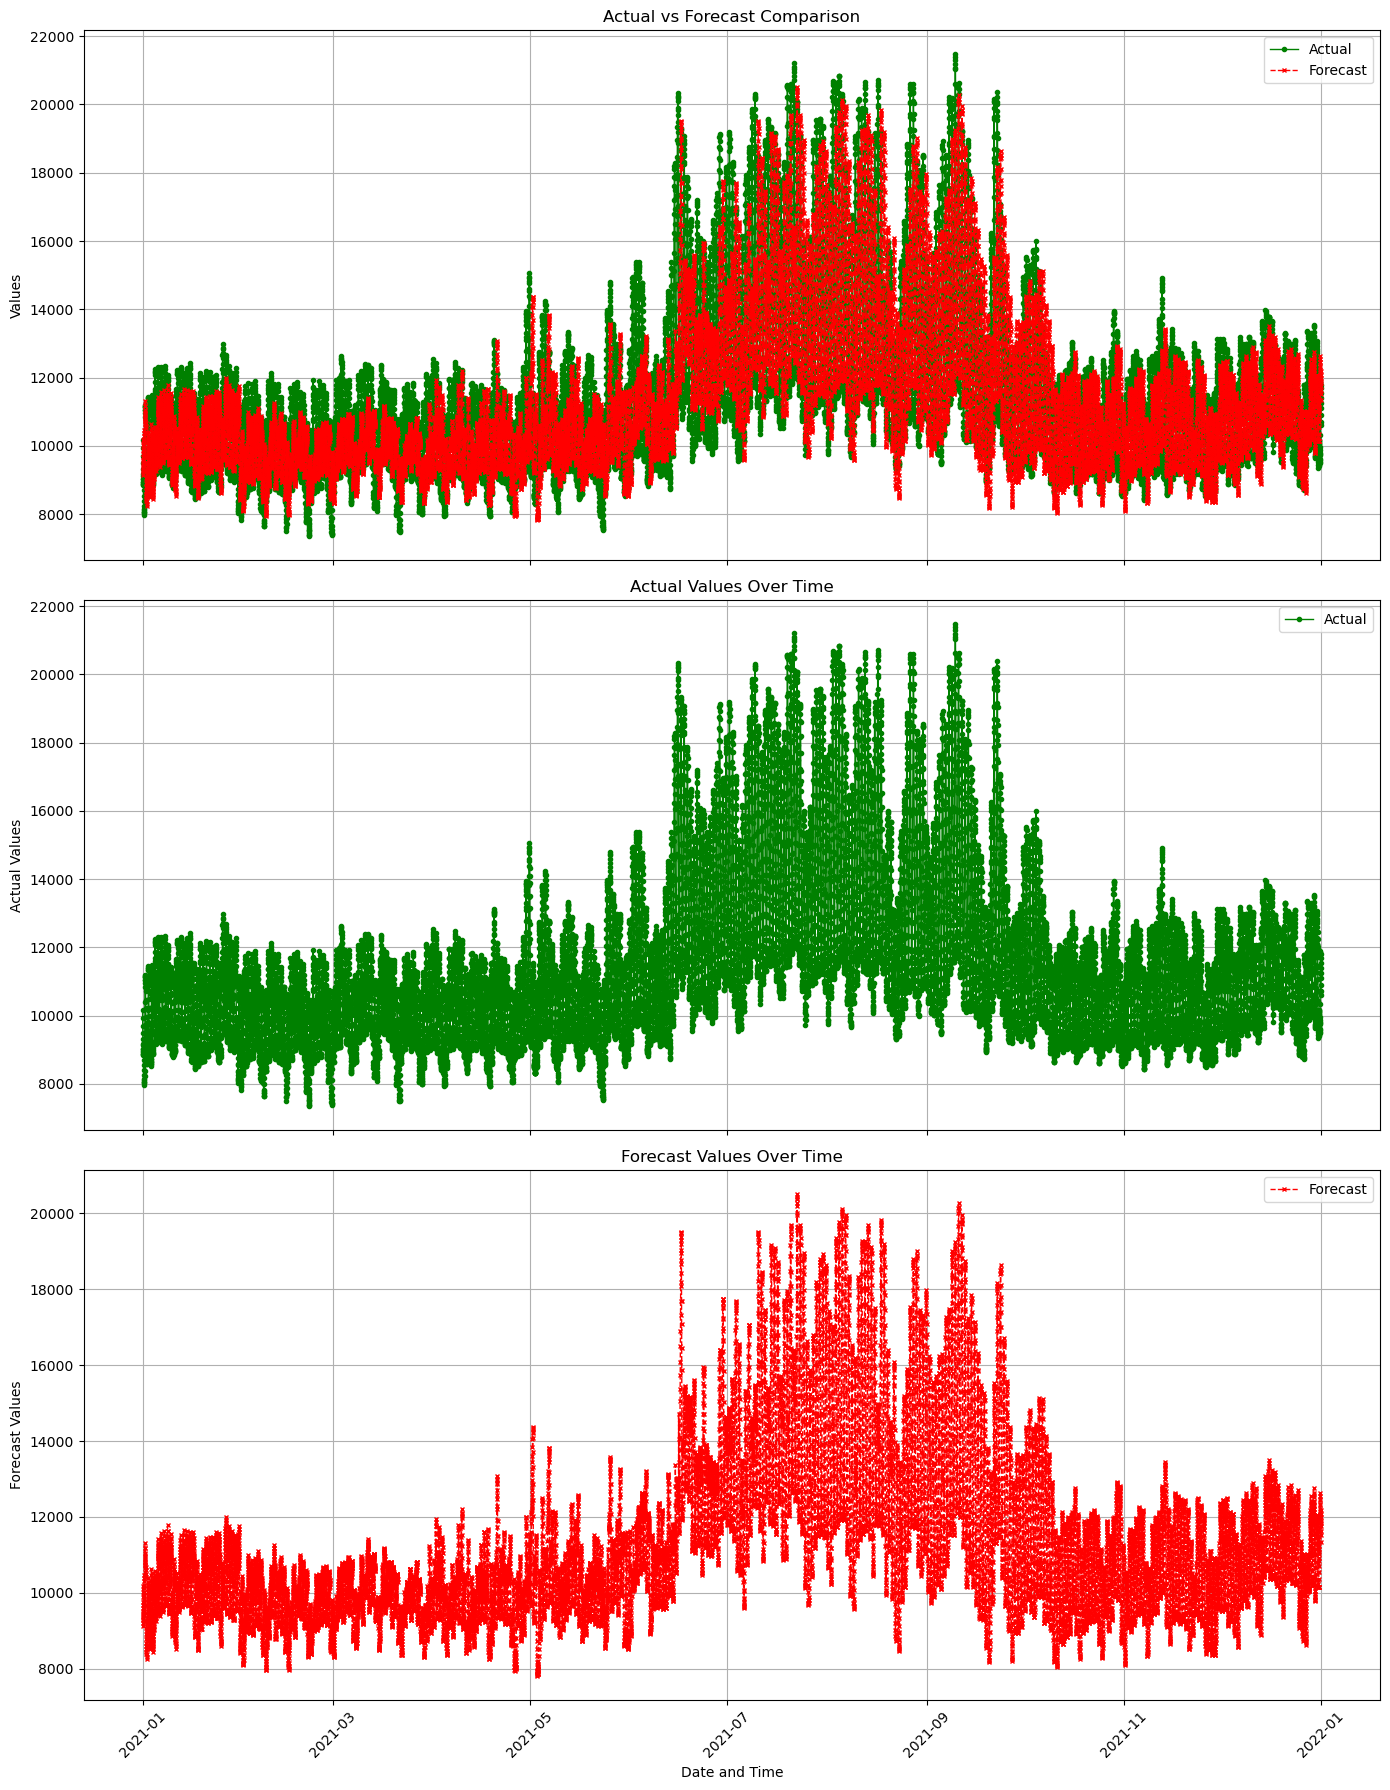

In [3]:
file_path = 'sarima_rolling_forecast5.csv'
data = pd.read_csv(file_path)
data['Date and Time'] = pd.to_datetime(data['Date and Time'])  

# Creating a figure with 3 subplots
fig, axs = plt.subplots(3, 1, figsize=(14, 18), sharex=True)

# Combined Plot for Actual and Forecast
axs[0].plot(data['Date and Time'], data['Actual'], label='Actual', color='green', marker='o', markersize=3, linestyle='-', linewidth=1)
axs[0].plot(data['Date and Time'], data['Forecast'], label='Forecast', color='red', marker='x', markersize=3, linestyle='--', linewidth=1)
axs[0].set_title('Actual vs Forecast Comparison')
axs[0].set_ylabel('Values')
axs[0].legend()
axs[0].grid(True)

# Separating Plot for Actual values
axs[1].plot(data['Date and Time'], data['Actual'], label='Actual', color='green', marker='o', markersize=3, linestyle='-', linewidth=1)
axs[1].set_title('Actual Values Over Time')
axs[1].set_ylabel('Actual Values')
axs[1].legend()
axs[1].grid(True)

# Separating Plot for Forecast values
axs[2].plot(data['Date and Time'], data['Forecast'], label='Forecast', color='red', marker='x', markersize=3, linestyle='--', linewidth=1)
axs[2].set_title('Forecast Values Over Time')
axs[2].set_xlabel('Date and Time')
axs[2].set_ylabel('Forecast Values')
axs[2].legend()
axs[2].grid(True)

# Rotating date labels for better visibility
plt.xticks(rotation=45)
plt.tight_layout()

# Displaying the plot
plt.show()


#### From the graph we can see that SARIMA has effecively captured seasonlity .

### 1.3. Flagging actual and forecasted peak days for SARIMA one day ahead forecasting models output using 95th percentile approach

we have used the csv with sarima forecasts for 2021 data i.e. sarima_rolling_forecast5 for peld flagging using 95th percentile approach

In [1]:
# Loading the dataset
file_path = 'sarima_rolling_forecast5.csv' # SARIMA FORECASTS OF DEMAND THROUGHOUT 2021
df = pd.read_csv(file_path)

# Converting 'Date and Time' column to datetime format
df['Date and Time'] = pd.to_datetime(df['Date and Time'])

# Calculating the 95th percentile for actual and forecasted demand
actual_95th_percentile = df['Actual'].quantile(0.95)
forecast_95th_percentile = df['Forecast'].quantile(0.95)

# Flagging peak days with 1s and non-peak days with 0s for actual and forecasted demand
df['Actual_Peak_Flag'] = (df['Actual'] > actual_95th_percentile).astype(int)
df['Forecast_Peak_Flag'] = (df['Forecast'] > forecast_95th_percentile).astype(int)

# Extracting unique dates by grouping by day and keeping the maximum flag per day
df['Date'] = df['Date and Time'].dt.date
df_daily = df.groupby('Date').agg({
    'Actual': 'max',
    'Forecast': 'max',
    'Actual_Peak_Flag': 'max',
    'Forecast_Peak_Flag': 'max'
}).reset_index()

# Including actual and forecasted demand values in the output CSV
df_daily['Actual_Demand'] = df.groupby('Date')['Actual'].max().values
df_daily['Forecast_Demand'] = df.groupby('Date')['Forecast'].max().values

# Saving the flagged dataset with detailed Date and Time information
df.to_csv('sarima_rolling_forecast5_flagged90.csv', index=False)
df_daily.to_csv('sarima_rolling_forecast5_flagged_daily999.csv', index=False)# we will use this csv "sarima_rolling_forecast5_flagged_daily999.csv" to feed the meta classifier hybrid model.


# Counting the number of actual peak days, forecasted peak days, and matching peak days for unique dates
actual_peak_days_count_unique = df_daily['Actual_Peak_Flag'].sum()
forecasted_peak_days_count_unique = df_daily['Forecast_Peak_Flag'].sum()
matching_peak_days_count_unique = ((df_daily['Actual_Peak_Flag'] == 1) & (df_daily['Forecast_Peak_Flag'] == 1)).sum()

# Displaying the results
print(f'Total Unique Actual Peak Days: {actual_peak_days_count_unique}')
print(f'Total Unique Forecasted Peak Days: {forecasted_peak_days_count_unique}')
print(f'Matching Peak Days: {matching_peak_days_count_unique}')


Total Unique Actual Peak Days: 68
Total Unique Forecasted Peak Days: 61
Matching Peak Days: 48


### Result:
    Total Unique Actual Peak Days: 68
    Total Unique Forecasted Peak Days: 61
    Matching Peak Days: 48


 we will use this csv "sarima_rolling_forecast5_flagged_daily999.csv" to feed the meta classifier hybrid model. sarima_rolling_forecast5_flagged_daily999.csv is having pelds forecasted by SARIMA model by using 95th perctile method and we will feed this to meta classifier hybrid model.